https://www.kaggle.com/code/jaime44/netflix-movie-recommendation/edit

In [1]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en un entorno local.


## *Last edit by DLao - 2020/09 updated with full data*



















<br>
<br>


![](https://cdn.statically.io/img/thakoni.com/f=auto%2Cq=30/wp-content/uploads/2020/06/1591106722_Lucifer-Season-5-Release-Date-Cast-Netflix-And-Everything-You.jpg)
# Netflix Analytics - Movie Recommendation through Correlations / CF
<br>

I love Netflix! Everyone does?

This project aims to build a movie recommendation mechanism within Netflix. The dataset I used here come directly from Netflix. It consists of 4 text data files, each file contains over 20M rows, i.e. over 4K movies and 400K customers. All together **over 17K movies** and **500K+ customers**!

<br>
One of the major challenges is to get all these data loaded into the Kernel for analysis, I have encountered many times of Kernel running out of memory and tried many different ways of how to do it more efficiently. Welcome any suggestions!!!

This kernel will be consistently be updated! Welcome any suggestions! Let's get started!

<br>
Feel free to fork and upvote if this notebook is helpful to you in some ways!


## Table of Content:

* Objective

* Data manipulation
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    
* Recommendation models
    -  Recommend with Collaborative Filtering (*Edit on 2017/11/07*)
    -  Recommend with Pearsons' R correlation

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>

# Data manipulation

## Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

Let's import the library we needed before we get started:

In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Next let's load first data file and get a feeling of how huge the dataset is:

In [3]:
# # Skip date
# df1 = pd.read_csv(path_absolute+"combined_data_1.txt", header = None, names = ['userId', 'rating'], usecols = [0,1])

# df1['rating'] = df1['rating'].astype(float)

# print('Dataset 1 shape: {}'.format(df1.shape))
# print('-Dataset examples-')
# print(df1.iloc[::50000, :])

In [4]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
df_ratings_merge = df_ratings_merge.sample(n=50000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

df1 = df_ratings_merge.copy()

(8949372, 13)
(50000, 11)


In [5]:
df1['rating'] = df1['rating'].astype(float)

Let's try to load the 3 remaining dataset as well:

In [6]:
#df2 = pd.read_csv('../input/combined_data_2.txt', header = None, names = ['userId', 'rating'], usecols = [0,1])
#df3 = pd.read_csv('../input/combined_data_3.txt', header = None, names = ['userId', 'rating'], usecols = [0,1])
#df4 = pd.read_csv('../input/combined_data_4.txt', header = None, names = ['userId', 'rating'], usecols = [0,1])


#df2['rating'] = df2['rating'].astype(float)
#df3['rating'] = df3['rating'].astype(float)
#df4['rating'] = df4['rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

Now we combine datasets:

In [7]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::50000, :])

Full dataset shape: (50000, 11)
-Dataset examples-
   userId  movieId  timestamp_rt tag_by_user  timestamp_tags gen_tag  \
0   60101     2571    1053445162    dystopia      1244667471  hitman   

                title                  genres  tagId  relevance  rating  
0  Matrix, The (1999)  Action|Sci-Fi|Thriller    512    0.12625     5.0  


## Data viewing

Let's give a first look on how the data spread:

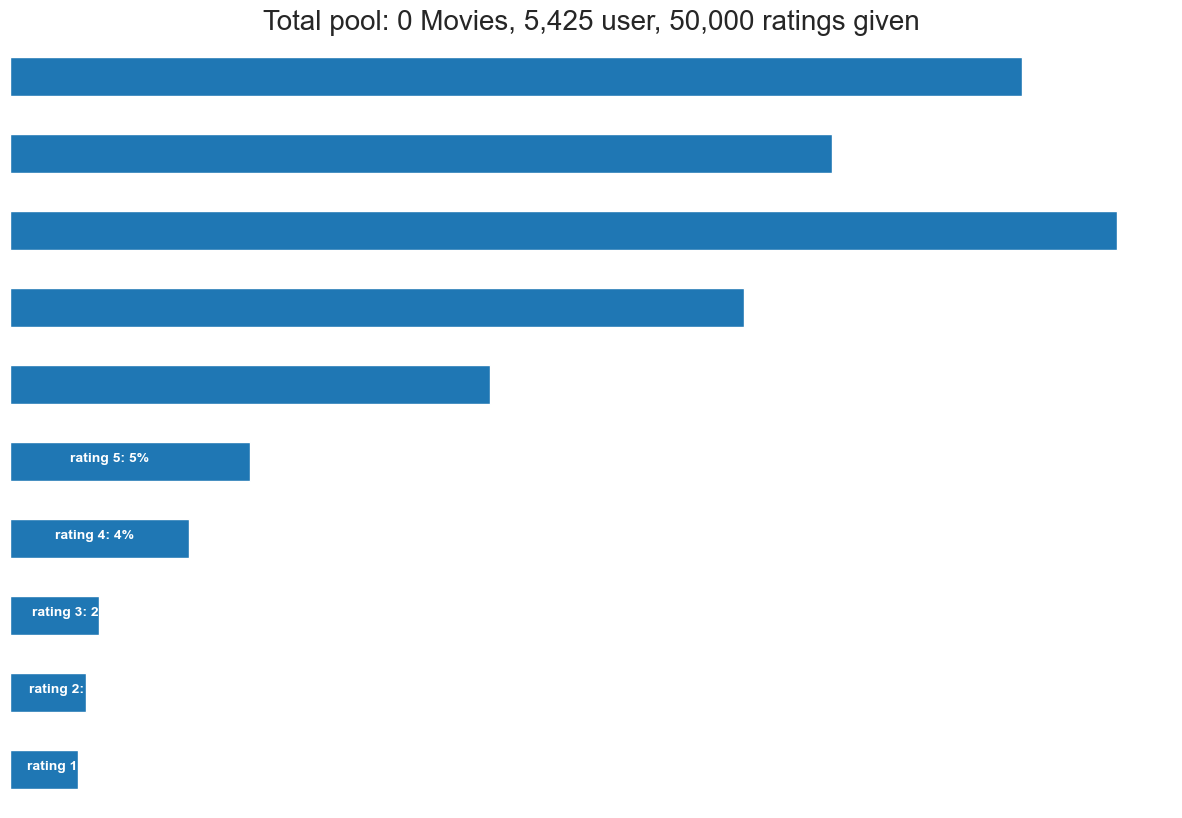

In [8]:
p = df.groupby('rating')['rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['userId'].nunique() - movie_count

# get rating count
rating_count = df['userId'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} user, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [15]:
import pandas as pd
import numpy as np

# Encontrar los lugares donde hay valores nulos en la columna 'rating'
df_nan = pd.DataFrame(pd.isnull(df['rating']))
df_nan = df_nan[df_nan['rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    # Enfoque con numpy
    temp = np.full((1, i - j - 1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Considerar el último registro y su longitud correspondiente
if not df_nan.empty:
    # Enfoque con numpy
    last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
    movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: []
Length: 0


In [16]:
# Convertir movie_np a un array de NumPy antes de usar astype
movie_np = np.array(movie_np, dtype=int)

# Eliminar filas con valores nulos en la columna 'rating'
df = df[pd.notnull(df['rating'])]

# Añadir columnas 'mo' y 'userId'
df['mo'] = movie_np
df['userId'] = df['userId'].astype(int)

# Imprimir ejemplos del conjunto de datos
print('- Ejemplos del conjunto de datos -')
print(df.iloc[::50000, :])


ValueError: Length of values (0) does not match length of index (5)

## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('movieId')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('userId')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Now let's trim down our data, whats the difference in data size?

In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['movieId'].isin(drop_movie_list)]
df = df[~df['userId'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::50000, :])

Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [ ]:
df_p = pd.pivot_table(df,values='rating',index='userId',columns='movieId')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#userId_u = list(sorted(df['userId'].unique()))
#movieId_u = list(sorted(df['movieId'].unique()))
#data = df['rating'].tolist()
#row = df['userId'].astype('category', categories=userId_u).cat.codes
#col = df['movieId'].astype('category', categories=movieId_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(userId_u), len(movieId_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=userId_u, columns=movieId_u)
#df_p = df_p.replace(0, np.NaN)


## Data mapping

Now we load the movie mapping file:

In [ ]:
df_title = pd.read_csv(path_absolute+"movie_titles.csv", encoding = "ISO-8859-1", header = None, names = ['movieId', 'Year', 'Name'])
df_title.set_index('movieId', inplace = True)
print (df_title.head(10))

# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

Below is what user 783514 liked in the past:

In [ ]:
df_785314 = df[(df['userId'] == 785314) & (df['rating'] == 5)]
df_785314 = df_785314.set_index('movieId')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Let's predict which movies user 785314 would love to watch:

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['movieId'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['movieId'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('movieId', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

Hope it is a good read. I will keep updating this Kernel (more models etc). Welcome any suggestions!


In [ ]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    !pip install scikit-surprise
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/colaborative filter'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

In [ ]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
df_ratings_merge = df_ratings_merge.sample(n=500000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()



In [ ]:
df_p = df_ratings_merge.copy()
df_p.head()

In [ ]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Carga de datos
# (Asumiendo que ya tienes un DataFrame llamado 'df' con la estructura proporcionada)
data = df_p.drop_duplicates(subset=['userId', 'movieId'])

# Creación de la matriz de calificaciones
df_p = pd.pivot_table(df_p, values='rating', index='userId', columns='movieId')


# Modelo de Filtrado Colaborativo con SVD
reader = Reader()
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

# Generación de recomendaciones para un usuario específico con SVD
user_id = 7620
user = df[df['userId'] == user_id]
movies_rated_by_user = user.set_index('movieId')['title']
print(f"Movies liked by user {user_id}:")
print(movies_rated_by_user)

# Creación del conjunto de datos para entrenamiento
trainset = data.build_full_trainset()
svd.fit(trainset)

# Generación de recomendaciones para el usuario 7620
user['Estimate_Score'] = user['movieId'].apply(lambda x: svd.predict(user_id, x).est)
user_783514 = user.drop('movieId', axis=1)
user_783514 = user_783514.sort_values('Estimate_Score', ascending=False)
print(f"\nTop 10 movie recommendations for user {user_id}:")
print(user_783514[['title', 'Estimate_Score']].head(10))

# Función de recomendación basada en la correlación de Pearson
def recommend(movie_title, min_count):
    print("\nFor movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = df.index[df['title'] == movie_title]
    if not i.empty:
        i = i.tolist()[0]
        target = df_p[i]
        similar_to_target = df_p.corrwith(target)
        corr_target = pd.DataFrame(similar_to_target, columns=['PearsonR'])
        corr_target.dropna(inplace=True)
        corr_target = corr_target.sort_values('PearsonR', ascending=False)
        corr_target.index = corr_target.index.map(int)
        corr_target = corr_target.join(df[['title', 'rating']]).rename(columns={'title': 'Name', 'rating': 'mean'})
        print(corr_target[corr_target['rating'] > min_count][:10].to_string(index=False))
    else:
        print("Movie not found in the DataFrame")

# Ejemplos de recomendación basada en la correlación de Pearson
recommend("Harry Potter and the Goblet of Fire (2005)", 0)
# recommend("Welcome to Collinwood (2002)", 0)


In [ ]:
recommend("Harry Potter and the Goblet of Fire (2005)", 0)